# Virtual NDD trajectories

Here we explore in the model the possible mechanisms linking the structural changes to the observed functional differences between the normal and cognitively declined groups. 

Virtual trajectory in this context is an approach of taking the data of a control (normal) subject, building an indiviualized virtual brain model, alter gradually a candidate structural property, and simulate the functional data. What we hope to achieve is to produce a same effect on the summary statistics of the functional data as we are observing between the groups in the empirical measurements


In particular we will implement the following two alternatives:

1. postsynaptic connectiviy attenuation
2. increase in excitability of the limbic system

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
from src.data.data_loader import Synthetic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We start by picking a subject from the `NORM` group.

In [3]:
dset = Synthetic()

In [6]:
subject = dset.subjects[-1]

In [12]:
print(
    subject,
    dset.subjects_metadata.loc[subject].group
)

sub-115 NORM


## Postsynaptic attenuation

The structural change here is implemented as a decrease in connectivity within the limbic network and the outgoing links. In TVB, this can be achieved by decreasing the weigths in the columns of the connectivity matrix corresponding to the limbic regions. We start by preparing the mask $M$:

In [20]:
from tvb.simulator.lab import *

In [32]:
limbic_labels, limbic_idx, _, _, _, _ = dset.parcellation.load_limbic()

In [50]:
conn = dset.load_connectivity(subject)

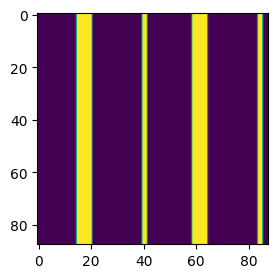

In [49]:
M = np.zeros_like(conn.weights)
M[:,limbic_idx] = 1.
plt.figure(figsize=(3,3));plt.imshow(M)

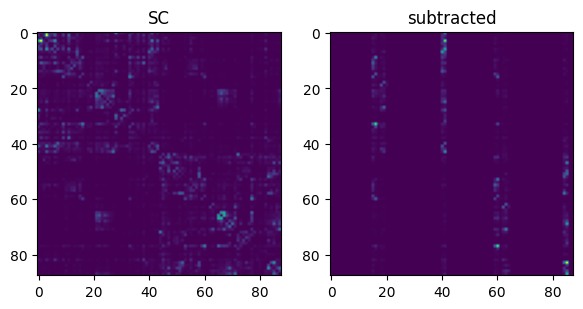

In [62]:
fig, axs = plt.subplots(ncols=2, figsize=(6,3))
axs[0].imshow(conn.weights)
axs[0].set(title='SC')
axs[1].imshow( M * conn.weights)
axs[1].set(title='subtracted')
fig.tight_layout()

The application of the mask is then repeated with a factor $\alpha \in [0,1]$ and each step is subjected to a parameter sweep over coupling scaling $G$ to identify the working point.

## Limbic Network Excitability

The excitability of the nodes of the network can be altered by the changing the $\eta$ parameter of the MPR model. In TVB, this can be accomplished by providng a vector of length of number of nodes instead of a single number when configuring the model. For example:

In [71]:
eta_0 = -4.6
eta_limbic = -3.

nn = conn.weights.shape[0]
eta_vector = np.ones(nn) * eta_0
eta_vector[limbic_idx] = eta_limbic

In [72]:
mpr = models.MontbrioPazoRoxin(
    J = np.r_[14.5],
    eta = eta_vector,
    tau  = np.r_[1.0],
    Delta = np.r_[0.7]
)

With this, we again construct a parameter sweep experiment spanning over a range of values for `eta_limbic`, identify the working points, and evaluate the summary statistics.